# Stocks screening and prediction

by Jia Rong, Pang

<a id='Top'></a>

Table Contents:
1. [Introduction](#Introduction)
2. [Data collection and web scrapping](#part2)
3. [Find out high potential stocks](#part3)
4. [Correlation analysis(Inspect linear relationship among stocks)](#part4)
5. [Time-series analysis on chosen pair of potential stocks](#part5)
6. [Conclusion](#Conclusion)

<a id='Introduction'></a>

## 1. Introduction

According to the statistics reported on CNN Money, there are nearly ten thounsand of stocks listed on USA stock market, this is quite challenging for us to pick some potential stocks. Comparing to USA, malaysia stock market is relatively a small market, but there are still amlost thounsand of publicly traded companies listed on the exchange, which is Kuala Lumpur Stock Exchange(KLSE) and also known as Bursa.
What are your strategies in picking the high potential stocks to invest in? Some common picking strategies are doing technical analysis, fundamental analysis and qualitative analysis.

Here, we are focusing on the analysis of **growth** and **variability** of stocks listed on KLSE, and some **performance indicators** will also be included in this analysis. We have created some **interactive stock screening visualization** that you can use to compare and pick the stocks based on **growth (reward), variability (risk) and performance indicators**.
On top of that, we will check the **linear relationship** among the high potential stocks by performing **correlation analysis**, which is useful in determining which pairs of stocks to select to **minimize the portfolio risk**. 

Let's start to download the stocks information and perform **quantitative analysis** to find out your favourite and high potential stocks.

The very first thing we should do is to import some useful python packages and custom functions we have created.

In [2]:
# Import python packages
import numpy as np
import pandas as pd
import time
from time import strftime
from datetime import datetime
from datetime import timedelta
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objs as go
from plotly.graph_objs import Scatter, Layout
from plotly.offline import init_notebook_mode, iplot
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [3]:
# Import custom user-defined functions
from stock_data_download import get_stocks_info
from stock_data_download import historical_extract
from stock_calculation import get_log_returns
from stock_calculation import metrics_calculation

We also need to define some variables used in our analysis. In this project, we are going to scrap the historical prices of stocks over last 5 years as you can see that we have set the duration to be five years. 
There are many platforms you can get the free real-time stock market qoutes, Yahoo Finance, Bloomberg and Google Finance are the most popular providers among them. Thanks to the open source community, we can use many free but powerful packages for fetching and analyzing financial data. But unfortunately, Yahoo and Google Finance have terminated their finanacial data API service in 2017. After doing some research, I finaly found an amazing website(<a>https://www.investing.com/</a>) which we can get **free stock quotes and historical prices**.

In [89]:
# Define variables  
user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/66.0.3359.181 Safari/537.36'
duration_year = 5
duration_day = 1
today = datetime.now().date()
end_date = today
start_date = today.replace(year=today.year-duration_year, day = today.day+duration_day)
tradeday_per_year = 252
country_code = 42 # code for KLSE in investing.com

<a id='part2' ></a>

## 2. Data Collection and Web Scrapping

We will focus on the quantitative analysis here and won't go into the particluars of web scrapping in this note. For those who are interested in the process of web scrapping, please refer to the functions in the custom module called <font color='green'>*stock_data_download.py*</font>. To perform **web scrapping**, we use some wonderful python packages, such as requests, BeautifulSoup and pandas.

Investing.com provide stock screener for researching and filtering the stocks based on some key parameters and metrics. Now, we are going to download the Malaysia stock screener list from this website(<a>https://www.investing.com/stock-screener</a>).

### Stock list

To fetch the data from website, we will make an **AJAX call to pass some specific parameters(etc. country code, dates) to the server** and the **API returns JSON-encoded or URL-encoded responses**. This makes us interact with the website easily. Alternatively, you can use Selenium to interact with the website. If you want to know how to fetch data using selenium, you can check the custom module called <font color='green'>*stock_data_download_selenium.py*</font> in the same repository.

To obtain the stock list of a specific country, you must specify the **country code** which is the key argument in our custom function <font color='green'>*get_stocks_info*</font>. 

Reference table for <font color='green'>*"country_code_investingcom"*</font>:
1. Asia: (1)Malaysia: 42, (2)Singapore: 36, (3)Australia: 25, (4)China: 37, (5)Japan: 35, (6)Hong Kong: 39
2. American: (2)United States: 5
3. Euro: (1)United Kingdom: 4, (2)Germany: 17

In [40]:
# Scrap stocks information from Investing.com and i3investor.com
stocks_list = get_stocks_info(country_code, user_agent)

We have successfully scrapped the information of stocks listed on country code 42 -page1
We have successfully scrapped the information of stocks listed on country code 42 -page2
We have successfully scrapped the information of stocks listed on country code 42 -page3
We have successfully scrapped the information of stocks listed on country code 42 -page4
We have successfully scrapped the information of stocks listed on country code 42 -page5
We have successfully scrapped the information of stocks listed on country code 42 -page6
We have successfully scrapped the information of stocks listed on country code 42 -page7
We have successfully scrapped the information of stocks listed on country code 42 -page8
We have successfully scrapped the information of stocks listed on country code 42 -page9
We have successfully scrapped the information of stocks listed on country code 42 -page10
We have successfully scrapped the information of stocks listed on country code 42 -page11
We have successfull

Alright. We have successfully scrapped the stock list from the webpages. Let's take a look at the Bursa(KLSE) stocks list we just scrapped from Investing.com screener list.

In [6]:
stocks_list.head(5)

,name,stock_symbol,security_type,sector,industry,link,price_weblink,pair_ID,exchange_ID,exchange,...,BullBear,CCI,HL,ROC,RSI,STOCH,STOCHRSI,UO,WilliamsR,MACD
0,7 Eleven Malaysia Holdings Bhd,SEVE,ORD,Services,Retail (Grocery),/equities/7-eleven-malaysia-holdings-bhd,https://www.investing.com/equities/7-eleven-ma...,950488,62,Kuala Lumpur,...,-0.034,-52.7348,0.0000,-3.846,48.178,54.861,21.450,82.724,-58.333,0.000
1,A Rank Bhd,ARNK,ORD,Basic Materials,Metal Mining,/equities/a-rank-bhd,https://www.investing.com/equities/a-rank-bhd-...,950104,62,Kuala Lumpur,...,0.023,38.0068,0.0029,2.000,52.798,50.347,79.767,49.083,-31.250,0.000
2,ABM Fujiya Bhd,ABMF,ORD,Technology,Electronic Instr. & Controls,/equities/abm-fujiya-bhd,https://www.investing.com/equities/abm-fujiya-...,950072,62,Kuala Lumpur,...,0.012,45.7266,0.0079,3.659,50.089,50.877,56.475,60.064,-47.368,-0.003
3,AE Multi Holdings Bhd,AEMU,ORD,Technology,Semiconductors,/equities/ae-multi-holdings-bhd,https://www.investing.com/equities/ae-multi-ho...,950079,62,Kuala Lumpur,...,-0.002,-55.5301,-0.0021,-3.125,51.039,15.992,16.675,48.753,-85.714,0.002
4,AEON Co (Malaysia) Bhd,AEOM,ORD,Services,Retail (Department & Discount),/equities/aeon-co-(m)-bhd,https://www.investing.com/equities/aeon-co-(m)...,950080,62,Kuala Lumpur,...,0.114,8.4946,0.0000,-6.977,58.693,58.753,26.485,42.463,-42.857,0.078


In [7]:
print('Statistics about stocks list:\n\n', stocks_list.describe())
print('Unique value in columns of stocks list:\n')
print(stocks_list.count())

Statistics about stocks list:

             pair_ID  exchange_ID        last  pair_change_percent(%)  \
count  9.120000e+02        912.0  912.000000              912.000000   
mean   8.643286e+05         62.0    1.921310                0.774145   
std    2.830335e+05          0.0    6.432929                4.631215   
min    4.160200e+04         62.0    0.005000              -16.670000   
25%    9.501988e+05         62.0    0.280000                0.000000   
50%    9.504355e+05         62.0    0.660000                0.000000   
75%    9.585600e+05         62.0    1.445000                1.492500   
max    1.075588e+06         62.0  146.700000               76.000000   

       daily_change(%)  week_change(%)  month_change(%)  ytd_change(%)  \
count       912.000000      912.000000       912.000000     908.000000   
mean          0.774145        3.949156         0.557182     -11.305430   
std           4.631215        9.819788        15.133068      23.780379   
min         -16.670000 

### Historical prices

As you can see, we have scrapped the information of 912 stocks listed on KLSE. Now, it is time to download the historical price of each stocks in our list.

The variables <font color='green'>*'start_date'*</font> and <font color='green'>*'end_date'*</font>  have been defined at the beginning of this note. The custom function <font color='green'>*historical_extract*</font> is used for **fetching the historical prices** of stocks over the last 5 years. This take quite a long time to process, please remember to save the information as a pickle file that you won't need to run this step over and over again.

In [8]:
# Scrap the historical prices of stocks
historical_data = list(map(lambda x: historical_extract(x,start_date,end_date,user_agent), stocks_list['price_weblink'].values))

https://www.investing.com/equities/7-eleven-malaysia-holdings-bhd-historical-data


C:\anaconda\Anaconda3\lib\site-packages\bs4\builder\_lxml.py:250: DeprecationWarning:

inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()



https://www.investing.com/equities/a-rank-bhd-historical-data
https://www.investing.com/equities/abm-fujiya-bhd-historical-data
https://www.investing.com/equities/ae-multi-holdings-bhd-historical-data
https://www.investing.com/equities/aeon-co-(m)-bhd-historical-data
https://www.investing.com/equities/affin-holdings-bhd-historical-data
https://www.investing.com/equities/ahb-holdings-bhd-historical-data
https://www.investing.com/equities/ammb-holdings-bhd-historical-data
https://www.investing.com/equities/apb-resources-bhd-historical-data
https://www.investing.com/equities/apft-bhd-historical-data
https://www.investing.com/equities/apm-automotive-holdings-bhd-historical-data
https://www.investing.com/equities/ark-resources-bhd-historical-data
https://www.investing.com/equities/at-systematization-bhd-historical-data
https://www.investing.com/equities/atta-global-pref-historical-data
https://www.investing.com/equities/awc-bhd-historical-data
https://www.investing.com/equities/tahps-group-

https://www.investing.com/equities/ccm-duopharma-biotech-bhd-historical-data
https://www.investing.com/equities/ci-holdings-bhd-historical-data
https://www.investing.com/equities/century-logistics-holdings-bhd-historical-data
https://www.investing.com/equities/cme-group-bhd-historical-data
https://www.investing.com/equities/cn-asia-corporation-bhd-historical-data
https://www.investing.com/equities/cni-holdings-bhd-historical-data
https://www.investing.com/equities/csc-steel-holdings-bhd-historical-data
https://www.investing.com/equities/cyl-corporation-bhd-historical-data
https://www.investing.com/equities/cabnet-holdings-bhd-historical-data
https://www.investing.com/equities/caely-holdings-bhd-historical-data
https://www.investing.com/equities/cahya-mata-sarawak-bhd-historical-data
https://www.investing.com/equities/can-one-bhd-historical-data
https://www.investing.com/equities/capitamalls-malaysia-trust-historical-data
https://www.investing.com/equities/careplus-group-bhd-historical-

https://www.investing.com/equities/evergreen-fibreboard-bhd-historical-data
https://www.investing.com/equities/eversafe-rubber-bhd-historical-data
https://www.investing.com/equities/eversendai-corporation-bhd-historical-data
https://www.investing.com/equities/ewein-bhd-historical-data
https://www.investing.com/equities/excel-force-msc-bhd-historical-data
https://www.investing.com/equities/facb-industries-incorporated-historical-data
https://www.investing.com/equities/fcw-holdings-bhd-historical-data
https://www.investing.com/equities/fsbm-holdings-bhd-historical-data
https://www.investing.com/equities/faber-group-bhd-historical-data
https://www.investing.com/equities/fajarbaru-builder-group-bhd-historical-data
https://www.investing.com/equities/far-east-holdings-bhd-historical-data
https://www.investing.com/equities/farlim-group-(malaysia)-bhd-historical-data
https://www.investing.com/equities/favelle-favco-bhd-historical-data
https://www.investing.com/equities/federal-furniture-holdin

https://www.investing.com/equities/iris-corporation-bhd-historical-data
https://www.investing.com/equities/ibraco-bhd-historical-data
https://www.investing.com/equities/icon-offshore-bhd-historical-data
https://www.investing.com/equities/ideal-jacobs-malaysia-corporation-historical-data
https://www.investing.com/equities/ideal-united-bintang-bhd-historical-data
https://www.investing.com/equities/ikhmas-jaya-group-bhd-historical-data
https://www.investing.com/equities/imaspro-corporation-bhd-historical-data
https://www.investing.com/equities/inari-amertron-bhd-historical-data
https://www.investing.com/equities/inch-kenneth-kajang-rubber-plc-historical-data
https://www.investing.com/equities/industronics-bhd-historical-data
https://www.investing.com/equities/inix-technologies-holdings-bhd-historical-data
https://www.investing.com/equities/innity-corporation-bhd-historical-data
https://www.investing.com/equities/innoprise-plantations-bhd-historical-data
https://www.investing.com/equities/

https://www.investing.com/equities/lii-hen-industries-bhd-historical-data
https://www.investing.com/equities/lingkaran-trans-kota-holdings-bhd-historical-data
https://www.investing.com/equities/lion-forest-industries-bhd-historical-data
https://www.investing.com/equities/lion-industries-corp-historical-data
https://www.investing.com/equities/london-biscuits-bhd-historical-data
https://www.investing.com/equities/lotte-chemical-titan-historical-data
https://www.investing.com/equities/luster-industries-bhd-historical-data
https://www.investing.com/equities/luxchem-corporation-bhd-historical-data
https://www.investing.com/equities/lysaght-galvanized-steel-historical-data
https://www.investing.com/equities/m-k-land-holdings-bhd-historical-data
https://www.investing.com/equities/m-mode-bhd-historical-data
https://www.investing.com/equities/m-n-c-wireless-bhd-historical-data
https://www.investing.com/equities/m3-technologies-asia-bhd-historical-data
https://www.investing.com/equities/maa-grou

https://www.investing.com/equities/ni-hsin-resources-bhd-historical-data
https://www.investing.com/equities/niche-capital-emas-holdings-historical-data
https://www.investing.com/equities/notion-vtec-bhd-historical-data
https://www.investing.com/equities/nova-msc-bhd-historical-data
https://www.investing.com/equities/nylex-malaysia-bhd-historical-data
https://www.investing.com/equities/ocb-bhd-historical-data
https://www.investing.com/equities/ock-group-bhd-historical-data
https://www.investing.com/equities/oc-resources-bhd-historical-data
https://www.investing.com/equities/takaso-resources-bhd-historical-data
https://www.investing.com/equities/opcom-holdings-bhd-historical-data
https://www.investing.com/equities/osk-holdings-bhd-historical-data
https://www.investing.com/equities/osk-ventures-international-bhd-historical-data
https://www.investing.com/equities/oceancash-pacific-bhd-historical-data
https://www.investing.com/equities/oka-corporation-bhd-historical-data
https://www.investi

https://www.investing.com/equities/tecnic-group-bhd-historical-data
https://www.investing.com/equities/rubberex-corporation-m-historical-data
https://www.investing.com/equities/s-p-setia-bhd-historical-data
https://www.investing.com/equities/sbc-corp-bhd-historical-data
https://www.investing.com/equities/sc-estate-builder-bhd-historical-data
https://www.investing.com/equities/scc-holdings-bhd-historical-data
https://www.investing.com/equities/scgm-bhd-historical-data
https://www.investing.com/equities/sch-group-bhd-historical-data
https://www.investing.com/equities/seal-incorporated-bhd-historical-data
https://www.investing.com/equities/seg-international-bhd-historical-data
https://www.investing.com/equities/shh-resources-holdings-bhd-historical-data
https://www.investing.com/equities/shl-consolidated-bhd-historical-data
https://www.investing.com/equities/sig-gases-bhd-historical-data
https://www.investing.com/equities/skb-shutters-corporation-bhd-historical-data
https://www.investing.

https://www.investing.com/equities/tadmax-resources-bhd-historical-data
https://www.investing.com/equities/talam-transform-bhd-historical-data
https://www.investing.com/equities/taliworks-corporation-bhd-historical-data
https://www.investing.com/equities/tambun-indah-land-bhd-historical-data
https://www.investing.com/equities/tan-chong-motor-holdings-bhd-historical-data
https://www.investing.com/equities/tanco-holdings-bhd-historical-data
https://www.investing.com/equities/tasco-bhd-historical-data
https://www.investing.com/equities/tasek-corporation-bhd-historical-data
https://www.investing.com/equities/tatt-giap-group-bhd-historical-data
https://www.investing.com/equities/techfast-holdings-bhd-historical-data
https://www.investing.com/equities/technodex-bhd-historical-data
https://www.investing.com/equities/teck-guan-perdana-bhd-historical-data
https://www.investing.com/equities/tek-seng-holdings-bhd-historical-data
https://www.investing.com/equities/tekala-corporation-bhd-historical

We finally finish downloading the historical prices of almost thousand of stocks listed on KLSE. The output of this step are a **dataframe of historical prices with the sector information and stock code**. 

In [13]:
historical_data[0]

(             Date  Price   Open   High    Low     Vol. Change %
 0    Jun 07, 2018  1.500  1.490  1.500  1.480  120.50K    0.67%
 1    Jun 06, 2018  1.490  1.500  1.500  1.470  370.30K   -0.67%
 2    Jun 05, 2018  1.500  1.490  1.500  1.470  141.20K    0.00%
 3    Jun 04, 2018  1.500  1.470  1.500  1.460  145.50K   -0.66%
 4    Jun 01, 2018  1.510  1.460  1.510  1.460  152.40K   -1.31%
 5    May 31, 2018  1.530  1.460  1.530  1.450  832.30K    2.00%
 6    May 30, 2018  1.500  1.500  1.500  1.460  296.50K    0.00%
 7    May 28, 2018  1.500  1.470  1.500  1.450  303.10K   -0.66%
 8    May 25, 2018  1.510  1.460  1.530  1.450  450.90K   -1.31%
 9    May 24, 2018  1.530  1.490  1.530  1.490   27.20K    3.38%
 10   May 23, 2018  1.480  1.550  1.550  1.480    1.00M   -4.52%
 11   May 22, 2018  1.550  1.550  1.560  1.550   38.00K   -0.64%
 12   May 21, 2018  1.560  1.500  1.560  1.500    1.05M    0.65%
 13   May 18, 2018  1.550  1.560  1.570  1.550   74.30K   -0.64%
 14   May 17, 2018  1.560

In [14]:
# store data as respective columns in dataframe
stocks_list['GICS_sector'] = list(map(lambda x: str(x[1]), historical_data))
stocks_list['stock_code'] = list(map(lambda x: str(x[2]), historical_data))
stocks_list['historical_price'] = list(map(lambda x: x[0], historical_data))
stocks_list['GICS_sector'] = stocks_list['GICS_sector'].astype('category')

In [15]:
stocks_list.head(5)

,name,stock_symbol,security_type,sector,industry,link,price_weblink,pair_ID,exchange_ID,exchange,...,ROC,RSI,STOCH,STOCHRSI,UO,WilliamsR,MACD,GICS_sector,stock_code,historical_price
0,7 Eleven Malaysia Holdings Bhd,SEVE,ORD,Services,Retail (Grocery),/equities/7-eleven-malaysia-holdings-bhd,https://www.investing.com/equities/7-eleven-ma...,950488,62,Kuala Lumpur,...,-3.846,48.178,54.861,21.450,82.724,-58.333,0.000,Trading&Services,5250,Date Price Open High Low ...
1,A Rank Bhd,ARNK,ORD,Basic Materials,Metal Mining,/equities/a-rank-bhd,https://www.investing.com/equities/a-rank-bhd-...,950104,62,Kuala Lumpur,...,2.000,52.798,50.347,79.767,49.083,-31.250,0.000,Industrial Products,7214,Date Price Open High Low...
2,ABM Fujiya Bhd,ABMF,ORD,Technology,Electronic Instr. & Controls,/equities/abm-fujiya-bhd,https://www.investing.com/equities/abm-fujiya-...,950072,62,Kuala Lumpur,...,3.659,50.089,50.877,56.475,60.064,-47.368,-0.003,Industrial Products,5198,Date Price Open High Low ...
3,AE Multi Holdings Bhd,AEMU,ORD,Technology,Semiconductors,/equities/ae-multi-holdings-bhd,https://www.investing.com/equities/ae-multi-ho...,950079,62,Kuala Lumpur,...,-3.125,51.039,15.992,16.675,48.753,-85.714,0.002,Industrial Products,7146,Date Price Open High Low...
4,AEON Co (Malaysia) Bhd,AEOM,ORD,Services,Retail (Department & Discount),/equities/aeon-co-(m)-bhd,https://www.investing.com/equities/aeon-co-(m)...,950080,62,Kuala Lumpur,...,-6.977,58.693,58.753,26.485,42.463,-42.857,0.078,Trading&Services,6599,Date Price Open High Low...


In [41]:
# Save data as pickle file
#stocks_list.to_pickle('stocks_list.pickle')
# Read pickle file
stocks_list = pd.read_pickle('stocks_list.pickle')

The web scrapping has been done and all the information we need from online are now ready. We are moving to the quantitative analysis in part 3.

<a id='part3' ></a>

## 3. Find out high potential stocks

### Exploratory Data Analysis

Stock price and financial performance indicators varies from industry to industry. The financial performance indicators are meaningless unless taking sector into consideration. We create bar graph and interactive pie chart for checking the number and percentage of stocks in the stock market list.

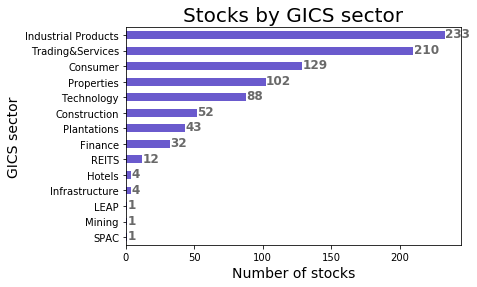

In [42]:
# 1. Bar Chart
ax1 = stocks_list['GICS_sector'].value_counts().sort_values().plot(kind='barh', color='slateblue')
ax1.set_title('Stocks by GICS sector', size=20)
ax1.set_xlabel('Number of stocks', size=14)
ax1.set_ylabel('GICS sector', size=14)
for i in ax1.patches:
    ax1.text(i.get_width()+0.25, i.get_y()+0.1, str(i.get_width()), color='dimgrey', fontweight='bold', fontsize=12)
plt.show()

In [43]:
init_notebook_mode(connected=True)         # initiate notebook for offline plot

# 2. Interactive Pie Chart
sector_series = pd.DataFrame(stocks_list['GICS_sector'].value_counts())
iplot({
        "data":[go.Pie(values = sector_series['GICS_sector'], labels = sector_series.index, 
                       name = "Bursa Stocks", hole = .6,)],
        "layout":Layout(title="Stocks by GICS sector")
})

These plots show us that the **top 3 sector of stocks in Malaysia are industrial products, trading&services and consumer** respectively, which totally account for **62.6%** of stocks in Malaysia stock market.  

### Calculate the return and risk of stocks 

The goal of this analysis is to find out the potential companies with **high growth and low variability**, and give us recommendation on the stocks with **rewarding and less risky**. We have created a function <font color='green'>*get_log_returns*</font> to calculate the **log returns** of stocks which we have scrapped in last section. This function can be used to calculate the daily, monthly and yearly log returns by setting the argument <font color='green'>*'period_options'*</font>. The log returns is basically the natural logarithms of the ratio of current value to last value.

Now, we are going to calculate the log returns of stocks based on the historical price using our custom function <font color='green'>*get_log_returns*</font>. We can get the **mean and standard deviation of the log returns** once the log returns are ready.

In [44]:
stocks_list['log_returns'] = list(map(lambda x: get_log_returns(x,'daily'), stocks_list['historical_price'].values))
stocks_list['mean_log_returns'] = (stocks_list['log_returns']).apply(lambda x: np.nanmean(x['return_value']))
stocks_list['sd_log_returns'] = (stocks_list['log_returns']).apply(lambda x: np.nanstd(x['return_value']))
stocks_list['trade_days'] = stocks_list['historical_price'].apply(lambda x: len(x['Price']))

In [45]:
cols = stocks_list.columns.tolist()
cols =  (cols[0:3] + cols[85:87]) + (cols[3:85] + cols[87:])
stocks_list = stocks_list[cols]

Let's peek into the mean and standard deviation of log returns before doing any further analysis.

In [46]:
# Take a look at the summary of mean & standard deviation of log returns
stocks_list['mean_log_returns'].describe()

count    912.000000
mean      -0.000154
std        0.000938
min       -0.007632
25%       -0.000596
50%       -0.000122
75%        0.000331
max        0.007974
Name: mean_log_returns, dtype: float64

In [47]:
stocks_list['sd_log_returns'].describe()

count    912.000000
mean       0.033844
std        0.018872
min        0.006553
25%        0.020413
50%        0.029735
75%        0.042367
max        0.186131
Name: sd_log_returns, dtype: float64

In [48]:
# median of mean daily returns
np.exp(-0.000122)

0.9998780074416974

In [49]:
# highest mean daily returns
np.exp(0.007974)

1.0080058770107623

This summary tells us some important information about the log returns of 912 stocks we are studying. From the summary above, we know that **half of the stocks have a mean daily returns lower than the previous day’s price**, and the **highest rewarding among these stocks is 0.008% more than previous day's price on average**.

We are going to compare all the stocks based on their **reward and risk** by checking an interactive visualization built with plotly package. You can zoom in on **sections of interest** and hover over the dots to gain insights about particular stocks.

In [50]:
# Set limits of xaxis and yaxis
xlower= 0.005; xupper= 0.04; ylower= -0.003; yupper= 0.008;

In [51]:
# Visualization(mean and std of log returns)
iplot({
    "data": [go.Scatter(x= stocks_list['sd_log_returns'], y= stocks_list['mean_log_returns'], showlegend= True,
                        mode = 'markers', marker=dict(size=(stocks_list['sales_growth_5yr(%)'])*(1/2),
                                                      opacity=0.6,
                                                      color=stocks_list['eps_growth_5yr(%)'], #set color equal to a variable
                                                      colorbar=dict(title='EPS growth(%) over last 5 years', titlefont=dict(size=10)), colorscale='Blue',showscale=True),
                        text = "<em>" + 'Company: ' + stocks_list['name'] + '</em><br>' +
                                '(' + stocks_list['stock_code'] + ')' + '<br>' +
                                list(map(lambda p: str(p), list(map(lambda x: 'GICS sector: {}'.format(x), stocks_list['GICS_sector'])))) + '<br>' +
                                'Industry: ' + stocks_list['industry'] + '<br>' +
                                list(map(lambda p: str(p), list(map(lambda x: 'Last price: {}'.format(x), stocks_list['last'])))) + '<br>' +
                                list(map(lambda p: str(p), list(map(lambda x: 'No. of trade days: {}'.format(x), stocks_list['trade_days'])))) + '<br>' +
                                'Monthly call: ' + stocks_list['summary_monthly'] + '<br>' +
                                'Weekly call: ' + stocks_list['summary_weekly'] + '<br>' +
                                'Daily call: ' + stocks_list['summary_daily']
                                #'Change of Price last 3 years(%): ' + stocks_list['3year_change(%)']
                                #'Earnings Per Share change(TTM): ' + stocks_list['eps_TTM_change_1yr(%)'] + '<br>'
                                #'Net profit margin(%): ' + stocks_list['netprofit_margin_TTM(%)']
                                )],
    "layout": Layout(
                title="Malaysia Bursa Analysis: Stock Risk vs Reward, " + end_date.strftime("%m/%d/%Y"),
                xaxis=dict(title='Risk/Variability (StDev Log Returns)',
                           titlefont=dict(family='Courier New, monospace',size=16,color='black'), range=[xlower, xupper]),
                yaxis=dict(title='Reward/Growth (Mean Log Returns)',
                           titlefont=dict(family='Courier New, monospace',size=16,color='black'), range=[ylower, yupper])
                    )
})    


The exploratory analysis above have given us some good idea about **how the daily return of stocks distribute**. The next thing we want to do is **isolating the potential stocks with high mean and low standard deviation of daily returns**.

In [52]:
# Isolate stocks which have an unique combination of high mean and low standard deviation log returns
# Please take sector into consideration.
stocks_list['rank_mean_log_returns'] = stocks_list['mean_log_returns'].rank(ascending=0, method='dense')
stocks_list['rank_bysector_mean_log_returns'] = stocks_list.groupby('GICS_sector')['mean_log_returns'].rank(pct=False, ascending=0, method='dense')

days_difference = (end_date - start_date).days
stocks_tp = stocks_list[(stocks_list['rank_mean_log_returns'] <100) & (stocks_list['sd_log_returns']<np.percentile(stocks_list['sd_log_returns'],75))
                        & (stocks_list['trade_days']>0.5*days_difference)]
essential_indexes = ['name','GICS_sector','industry','stock_code','summary_monthly','summary_weekly','summary_daily','last','one_year_return(%)','market_cap','pe_ratio','revenue','eps','dividend_yield(%)','price_to_sales_TTM',
                     'price_to_cash_flow_MRQ','price_to_book_MRQ','eps_TTM_change_1yr(%)','eps_growth_5yr(%)','sales_TTM_change_1yr(%)','sales_growth_5yr(%)',
                     'netprofit_margin_TTM(%)','netprofit_margin_5yr(%)','dividend_yield_avg_5yr(%)','dividend_growth_rate(%)','historical_price',
                     'log_returns','mean_log_returns','sd_log_returns','trade_days']
stocks_tp = stocks_tp[essential_indexes].reset_index(drop=True)

In [53]:
stocks_tp.head()

,name,GICS_sector,industry,stock_code,summary_monthly,summary_weekly,summary_daily,last,one_year_return(%),market_cap,...,sales_growth_5yr(%),netprofit_margin_TTM(%),netprofit_margin_5yr(%),dividend_yield_avg_5yr(%),dividend_growth_rate(%),historical_price,log_returns,mean_log_returns,sd_log_returns,trade_days
0,AWC Bhd,Trading&Services,Business Services,7579,Sell,Strong Sell,Strong Sell,0.710,-33.33,190810000,...,22.98,9.76,8.72,2.00,NaN,Date Price Open High Low...,"Date return_value 0 Jun 07,...",0.000837,0.025950,1224
1,Ajinomoto Malaysia Bhd,Consumer,Chemical Manufacturing,2658,Strong Buy,Neutral,Strong Sell,22.400,3.67,1340000000,...,5.28,43.68,16.61,3.39,31.43,Date Price Open High Low...,"Date return_value 0 Jun 07,...",0.001395,0.015808,1166
2,Boon Koon Group Bhd,Industrial Products,Auto & Truck Manufacturers,7187,Neutral,Strong Sell,Strong Sell,0.440,2.33,130730000,...,-9.31,3.12,-2.76,NaN,NaN,Date Price Open High Low...,"Date return_value 0 Jun 07,...",0.000851,0.033944,1119
3,CCK Consolidated Holdings Bhd,Consumer,Fish/Livestock,7035,Strong Buy,Strong Buy,Strong Buy,1.990,109.94,596030000,...,NaN,5.79,NaN,NaN,44.22,Date Price Open High Low ...,"Date return_value 0 Jun 07, 2...",0.000873,0.034432,975
4,Caely Holdings Bhd,Consumer,Apparel/Accessories,7154,Strong Buy,Sell,Strong Sell,0.835,75.79,66800000,...,11.64,2.03,4.32,2.24,0.00,Date Price Open High Low...,"Date return_value 0 Jun 07,...",0.000910,0.034344,1126


In [54]:
# number of potential stocks 
len(stocks_tp)

50

We have stored the high potential stocks in the dataframe <font color='green'>*'stocks_tp'*</font>. The high potential stocks were selected based on the **criteria** we set, which has **top 100 highest mean daily returns** and **standard deviation of daily return below 75% percentile** among all stocks. We will now focus on these **50 selected potential stocks**. An interactive visualization is provided for us to explore and understand the information of the high potential stocks. 

In [55]:
iplot({
    "data": [go.Scatter(x= stocks_tp['sales_TTM_change_1yr(%)'], y= stocks_tp['mean_log_returns'], showlegend= True,
                        mode = 'markers', marker=dict(size=(stocks_tp['netprofit_margin_TTM(%)']),
                                                      opacity=0.6,
                                                      color=stocks_tp['eps_growth_5yr(%)'], #set color equal to a variable
                                                      colorbar=dict(title='EPS growth(%) over last 5 years', titlefont=dict(size=10)), colorscale='Blue',showscale=True),
                        text = "<em>" + 'Company: ' + stocks_tp['name'] + '</em><br>' +
                                '(' + stocks_tp['stock_code'] + ')' + '<br>' +
                                list(map(lambda p: str(p), list(map(lambda x: 'GICS sector: {}'.format(x), stocks_tp['GICS_sector'])))) + '<br>' +
                                'Industry: ' + stocks_tp['industry'] + '<br>' +
                                list(map(lambda p: str(p), list(map(lambda x: 'Last price: {}'.format(x), stocks_tp['last'])))) + '<br>' +
                                list(map(lambda p: str(p), list(map(lambda x: 'Revenue growth over 5 years(%): {}'.format(x), stocks_tp['sales_growth_5yr(%)'])))) + '<br>' +
                                list(map(lambda p: str(p), list(map(lambda x: 'Profit margin over 5 years(%): {}'.format(x), stocks_tp['netprofit_margin_5yr(%)'])))) + '<br>' +
                                list(map(lambda p: str(p), list(map(lambda x: 'EPS growth last year(%): {}'.format(x), stocks_tp['eps_TTM_change_1yr(%)'])))) + '<br>' +
                                list(map(lambda p: str(p), list(map(lambda x: 'Average dividend yield over 5 years(%): {}'.format(x), stocks_tp['dividend_yield_avg_5yr(%)'])))) + '<br>' +
                                list(map(lambda p: str(p), list(map(lambda x: 'Price/Earnings ratio: {}'.format(x), stocks_tp['pe_ratio'])))) + '<br>' +
                                'Monthly call: ' + stocks_tp['summary_monthly'] + '<br>' +
                                'Weekly call: ' + stocks_tp['summary_weekly'] + '<br>' +
                                'Daily call: ' + stocks_tp['summary_daily']
                                )],
    "layout": Layout(
                title="Malaysia Bursa Analysis: Reward vs Revenue growth(last year), " + end_date.strftime("%m/%d/%Y"),
                xaxis=dict(title='Revenue growth over latest year',
                           titlefont=dict(family='Courier New, monospace',size=16,color='black')),
                yaxis=dict(title='Reward/Growth (Mean Log Returns)',
                           titlefont=dict(family='Courier New, monospace',size=16,color='black'))
                    )
})    

From the interactive plot above, we can get some **valuable insights** which can help you make a **better decision** in choosing the stocks to invest in.

<a id='part4' ></a>

## 4. Correlation analysis(Inspect linear relationship among stocks)

In last section, we have successfully screen out the high potential stocks with high growth and less risky. We also need to **diversify our investment** so we don’t have all your eggs in one basket. To **balance the good historical performance and the investment diversification**, a **correlation assessment** can be performed to visualize which high potential stocks are least correlated. 

In [56]:
stocks_tp_reduced = stocks_tp.loc[:,['name','log_returns']]
stocks_tp_reduced = stocks_tp_reduced.reset_index(drop=True)

stocks_tp_unnest = pd.DataFrame()
for i in range(0,len(stocks_tp_reduced)):
    stocks_tp_reduced['log_returns'][i] = (stocks_tp_reduced['log_returns'][i].assign(name = stocks_tp_reduced['name'][i]).set_index('name').reset_index())
    stocks_tp_unnest = stocks_tp_unnest.append(stocks_tp_reduced['log_returns'][i])                                   

stocks_tp_unnest['Date'] = stocks_tp_unnest['Date'].apply(lambda x: datetime.strptime(x.lower(),("%b %d, %Y")).strftime("%Y-%m-%d"))
stocks_tp_spread = stocks_tp_unnest.pivot_table(values="return_value", index='Date', columns='name').dropna()

In [57]:
stocks_tp_spread.head(5)

name,AWC Bhd,Ajinomoto Malaysia Bhd,Boon Koon Group Bhd,CCK Consolidated Holdings Bhd,Caely Holdings Bhd,D O Green Technologies Bhd,Datasonic Group Bhd,Denko Industrial Corporation,Dufu Tech Corp Bhd,Eco World Develop Group,...,Scicom MSC Bhd,Sunsuria Bhd,Superlon Holdings Bhd,Syarikat Takaful Malaysia Bhd,Teo Seng Capital Bhd,UMS-Neiken Group Bhd,Unisem M Bhd,ViTrox Corporation Bhd,Wong Engineering Corporation Bhd,Yinson Holdings Bhd
Date,,,,,,,,,,,,,,,,,,,,,
2014-04-28,-0.018349,0.000000,0.000000,-0.017805,0.017700,-0.064539,0.041061,-0.018349,0.000000,-0.037982,...,-0.036368,-0.006630,-0.022118,0.006441,-0.060169,-0.006969,-0.016667,-0.023333,0.047628,0.001088
2014-06-18,0.037041,0.005013,0.000000,-0.011834,0.000000,0.000000,0.000000,0.018692,0.020619,0.000000,...,0.008929,-0.079529,0.045285,0.009274,0.070118,0.000000,-0.027213,0.026912,0.000000,-0.005854
2014-06-19,-0.018349,-0.001668,0.035091,0.005935,0.000000,0.078988,0.030459,-0.018692,0.020203,-0.008006,...,0.036010,-0.008043,-0.015385,-0.010828,-0.019078,-0.007326,-0.013889,-0.026912,0.000000,-0.003922
2014-06-24,-0.018019,0.003263,0.035091,0.005900,-0.019231,0.000000,0.005115,0.000000,-0.041673,-0.001801,...,-0.017298,-0.023146,0.043980,0.000000,0.011410,0.000000,0.000000,0.017628,-0.013514,0.011321
2014-07-17,0.000000,0.014623,0.000000,-0.005195,-0.018868,-0.013986,-0.020943,0.000000,0.133531,0.000000,...,0.000000,0.023305,-0.021944,-0.006211,-0.022815,0.056353,-0.023393,-0.004149,0.013334,-0.013606


The log returns are stored as a dataframe and we need to extract the daily returns of all stocks and integrate into a new dataframe <font color='green'>*'stocks_tp_unnest'*</font>. Next, we have to convert the data into the format required for correlation analysis, the prices of stocks are organized into the columns with corresponding date. Then, the correlation of stocks computed using the bulit-in function <font color='green'>*corr*</font>, and we are ready to visulize the correlations. 

In [58]:
stocks_tp_corr = stocks_tp_spread.corr()

In [59]:
stocks_tp_corr.head(5)

name,AWC Bhd,Ajinomoto Malaysia Bhd,Boon Koon Group Bhd,CCK Consolidated Holdings Bhd,Caely Holdings Bhd,D O Green Technologies Bhd,Datasonic Group Bhd,Denko Industrial Corporation,Dufu Tech Corp Bhd,Eco World Develop Group,...,Scicom MSC Bhd,Sunsuria Bhd,Superlon Holdings Bhd,Syarikat Takaful Malaysia Bhd,Teo Seng Capital Bhd,UMS-Neiken Group Bhd,Unisem M Bhd,ViTrox Corporation Bhd,Wong Engineering Corporation Bhd,Yinson Holdings Bhd
name,,,,,,,,,,,,,,,,,,,,,
AWC Bhd,1.000000,0.129537,0.085101,0.062013,0.263098,0.112367,0.461983,0.107122,0.180595,0.179722,...,0.134291,-0.109781,0.253766,0.030465,0.243218,0.075299,0.225448,0.331333,0.198254,0.272878
Ajinomoto Malaysia Bhd,0.129537,1.000000,0.180359,0.069494,0.069682,0.086003,0.226141,0.089910,0.132671,0.069365,...,0.042580,0.145829,0.246962,0.133413,0.027844,-0.005780,0.307956,0.116199,0.152504,0.086282
Boon Koon Group Bhd,0.085101,0.180359,1.000000,-0.025465,-0.004917,0.103637,0.098456,0.073813,0.022916,-0.055375,...,0.117809,0.092192,0.073290,0.017651,0.052638,0.101267,0.007351,0.076844,-0.035855,-0.063060
CCK Consolidated Holdings Bhd,0.062013,0.069494,-0.025465,1.000000,0.158769,0.171462,0.065476,0.031382,0.096107,0.182957,...,0.036556,0.155971,0.272246,0.087454,0.047929,0.046440,0.095015,-0.029883,0.065433,0.100130
Caely Holdings Bhd,0.263098,0.069682,-0.004917,0.158769,1.000000,0.115316,0.220885,0.147529,0.215261,0.162743,...,0.260001,0.047149,0.468760,0.164643,0.248244,-0.054192,0.203871,0.303123,0.218740,0.135805


The **hierarchically-clustered heatmap** help us identify the correlated stocks within the assigned clusters. To diversify the investment, we can choose the potential stocks from different clusters assigned by hierarchical clustering. Referring to the colorbar, the block in red has higher correlation while the blue has a lower correlation.

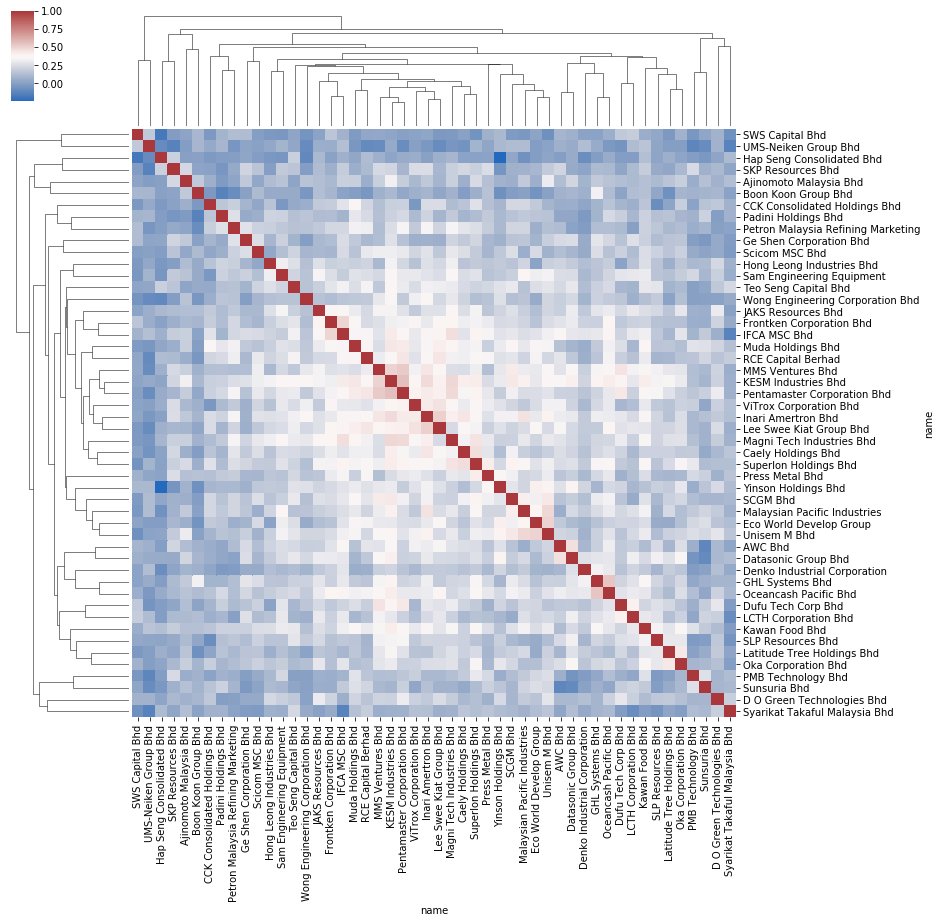

In [60]:
corrplot = sns.clustermap(data=stocks_tp_corr,  metric="correlation", annot=False, cmap='vlag', figsize=(13, 13))

<a id='part5' ></a>

## 5. Time-series analysis on chosen pair of potential stocks

So far, we have filtered some potential stocks based on their historical performance and the correlation. Let's try to **predict how the prices of chosen pair of potential stocks will go in the future**. Combining the **historical performance evaluation and time-series analysis**, we believe that we can find out some combninations of potential stocks worth for investing.    

In [61]:
# find out the highest correlation of each stock
stocks_tp_corr.apply(lambda x: abs(x).nlargest(2)[1])

name
AWC Bhd                               0.461983
Ajinomoto Malaysia Bhd                0.323717
Boon Koon Group Bhd                   0.330152
CCK Consolidated Holdings Bhd         0.362419
Caely Holdings Bhd                    0.468760
D O Green Technologies Bhd            0.312059
Datasonic Group Bhd                   0.461983
Denko Industrial Corporation          0.328019
Dufu Tech Corp Bhd                    0.449498
Eco World Develop Group               0.497943
Frontken Corporation Bhd              0.497421
GHL Systems Bhd                       0.542869
Ge Shen Corporation Bhd               0.284871
Hap Seng Consolidated Bhd             0.247964
Hong Leong Industries Bhd             0.332159
IFCA MSC Bhd                          0.497421
Inari Amertron Bhd                    0.508612
JAKS Resources Bhd                    0.396026
KESM Industries Bhd                   0.564503
Kawan Food Bhd                        0.419921
LCTH Corporation Bhd                  0.405926
Latitude

In [63]:
# Time-series analysis (Stocks can be chosen from potential stocks obtained above which are highly correlated)
stock_picked1 = 'Yinson Holdings Bhd'
stock_picked2 = 'Eco World Develop Group'

In [64]:
stock_price1 = stocks_tp.ix[list(stocks_tp['name']).index(stock_picked1),'historical_price'].copy()          
stock_price2 = stocks_tp.ix[list(stocks_tp['name']).index(stock_picked2),'historical_price'].copy()  

stock_price1['Date'] = pd.to_datetime(stock_price1['Date'].apply(lambda x: datetime.strptime(x.lower(),("%b %d, %Y")).strftime("%Y-%m-%d")))
stock_price2['Date'] = pd.to_datetime(stock_price2['Date'].apply(lambda x: datetime.strptime(x.lower(),("%b %d, %Y")).strftime("%Y-%m-%d")))

stock_price1 = stock_price1.sort_values('Date').reset_index(drop=True)
stock_price2 = stock_price2.sort_values('Date').reset_index(drop=True)

C:\anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated

C:\anaconda\Anaconda3\lib\site-packages\pandas\core\indexing.py:1020: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated



In [82]:
# Growth over last 5 years
start1 = stock_price1['y'].iloc[0]
end1 = stock_price1['y'].iloc[-1]
start2 = stock_price2['y'].iloc[0]
end2 = stock_price2['y'].iloc[-1]

growth_past_stock1 = (stock_price1['y'].iloc[-1] - stock_price1['y'].iloc[0]) / stock_price1['y'].iloc[0]
growth_past_stock2 = (stock_price2['y'].iloc[-1] - stock_price2['y'].iloc[0]) / stock_price2['y'].iloc[0]

In [90]:
day1 = (stock_price1['ds'].iloc[-1] - stock_price1['ds'].iloc[0]).days
day2 = (stock_price2['ds'].iloc[-1] - stock_price2['ds'].iloc[0]).days

CAGR1 = ((stock_price1['y'].iloc[-1] / stock_price1['y'].iloc[0]) **(1/(day1/tradeday_per_year))) - 1
CAGR2 = ((stock_price2['y'].iloc[-1] / stock_price2['y'].iloc[0]) **(1/(day2/tradeday_per_year))) - 1

In [91]:
print('Based on our calculation, the 5 year growth of stock price of \n' + 
      stock_picked1 + ' is ' + str(round(growth_past_stock1*100,2)) + ' % from RM' + str(start1) + ' to RM'+ str(end1) + ',\n' +
      stock_picked2 + ' is ' + str(round(growth_past_stock2*100,2)) +' % from RM' + str(start2) + ' to RM'+ str(end2) + '.')

Based on our calculation, the 5 year growth of stock price of 
Yinson Holdings Bhd is 204.55 % from RM1.517 to RM4.62,
Eco World Develop Group is 271.35 % from RM0.342 to RM1.27.


In [93]:
print('CAGR over last 5 years of \n'+
     stock_picked1 + ' is ' + str(round(CAGR1*100,2)) + ' %,\n' +
     stock_picked2 + ' is ' + str(round(CAGR2*100,2)) + '%.' )

CAGR over last 5 years of 
Yinson Holdings Bhd is 16.65 %,
Eco World Develop Group is 19.88%.


Looking at the statistics above, two stocks had very strong performance over last 5 years, their stock values have been risen around 3 times in 5 years horizon. Eco World has outperformed Yinson with a 19.88% compound annual growth rate and 271.35% growth over the last 5 year. But strong historical performance doesn't imply a good future performance, we have to **predict** the future values to confirm that we can **make good investment decisions**.

### Time-series modeling

We are going to create an **additive model** of stock prices data using the **Prophet forecasting package developed by Facebook**(<a>https://github.com/facebook/prophet</a>). Prophet is easy to understand but it is very powerful in time-series analysis. The idea behind the prophet package is decompose time series data into three components, which are **trends, seasonal effects and holiday/one-off effects**. Each of these components contribute additively to the observed time series, which means that the stocks price is the sum of trend component, seasonal component and the one-off effects.

Only two columns are needed for modelling time series data using Prophet package. We just keep the two variables needed and rename to the name required for the prophet model.

In [65]:
# Model time series with Prophet
col_keep = ['Date', 'Price']
stock_price1 = stock_price1[col_keep]
stock_price2 = stock_price2[col_keep]
# Prophet requires columns ds (Date) and y (value)
stock_price1 = stock_price1.rename(columns={'Date': 'ds','Price': 'y'})
stock_price2 = stock_price2.rename(columns={'Date': 'ds','Price': 'y'})

Once the data are prepared well, we are ready to model the time series data using Prophet package. We will create a **prophet model with 95% confidence interval** and without daily seasonality. Changepoints represent where a time series goes from increasing to decreasing or from increasing slowly to increasingly rapidly (or vice versa). They occur at the places with the greatest change in the rate of the time series. The changepoints are used to control the bias and variance tradeoff. We will use the default value for the changepoint.

This prophet model is then used for **predicting the stock price for next 365 days**. The forecasting results shown in the dataframe <font color='green'>*'stock1_forecast'*</font> and visualized in plot below.

In [66]:
# Make the prophet model and fit on the stock prices of Yinson
stock1_prophet = Prophet(interval_width=0.95, changepoint_prior_scale=0.05, daily_seasonality=False)
stock1_prophet.fit(stock_price1)

# Make a future dataframe for 1 year
stock1_forecast = stock1_prophet.make_future_dataframe(periods=365 * 1, freq='D')
# Make predictions
stock1_forecast = stock1_prophet.predict(stock1_forecast)
stock1_forecast.tail()

C:\anaconda\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
1585,2019-06-03,5.291247,4.287153,6.281541,4.230293,6.284762,-0.026486,-0.026486,-0.026486,0.0,0.0,0.0,-0.022101,-0.022101,-0.022101,-0.004385,-0.004385,-0.004385,5.264761
1586,2019-06-04,5.293823,4.285458,6.287836,4.236908,6.267165,-0.028383,-0.028383,-0.028383,0.0,0.0,0.0,-0.023197,-0.023197,-0.023197,-0.005186,-0.005186,-0.005186,5.265440
1587,2019-06-05,5.296400,4.283768,6.294131,4.220334,6.326774,-0.027759,-0.027759,-0.027759,0.0,0.0,0.0,-0.021555,-0.021555,-0.021555,-0.006204,-0.006204,-0.006204,5.268641
1588,2019-06-06,5.298976,4.282101,6.300426,4.209601,6.289711,-0.024956,-0.024956,-0.024956,0.0,0.0,0.0,-0.017597,-0.017597,-0.017597,-0.007359,-0.007359,-0.007359,5.274021
1589,2019-06-07,5.301553,4.280917,6.306721,4.217259,6.345865,-0.023879,-0.023879,-0.023879,0.0,0.0,0.0,-0.015312,-0.015312,-0.015312,-0.008567,-0.008567,-0.008567,5.277673


In [32]:
stock1_prophet.changepoints

39    2013-08-05
78    2013-10-02
117   2013-11-28
157   2014-01-29
196   2014-03-27
235   2014-05-23
274   2014-07-18
313   2014-09-17
352   2014-11-13
392   2015-01-12
431   2015-03-12
470   2015-05-08
509   2015-07-02
548   2015-08-27
587   2015-10-27
627   2015-12-23
666   2016-02-25
705   2016-04-20
744   2016-06-15
783   2016-08-12
822   2016-10-12
862   2016-12-07
901   2017-02-08
940   2017-04-05
979   2017-06-02
Name: ds, dtype: datetime64[ns]

Text(0.5,1,'Stock Price of Yinson Holdings Bhd')

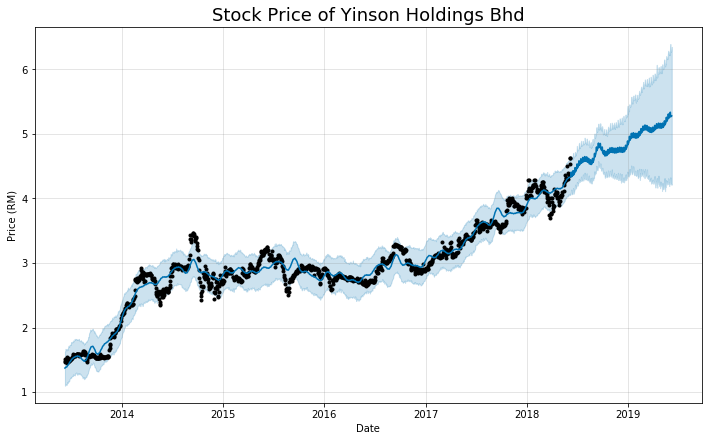

In [67]:
stock1_prophet.plot(stock1_forecast, xlabel = 'Date', ylabel = 'Price (RM)')
plt.title('Stock Price of '+stock_picked1, size=18)

As we discussed, prophet model is an additive model which include trend, seasonal and holiday effects. We can check the components of the model using <font color='green'>*plot_components*</font>.

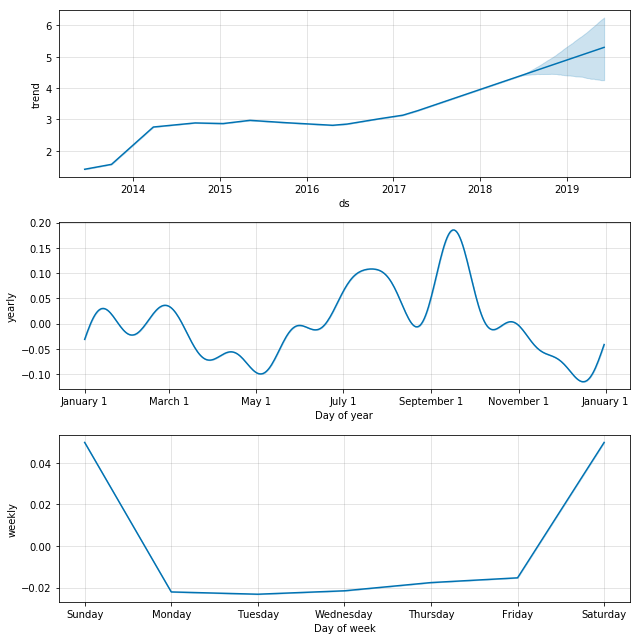

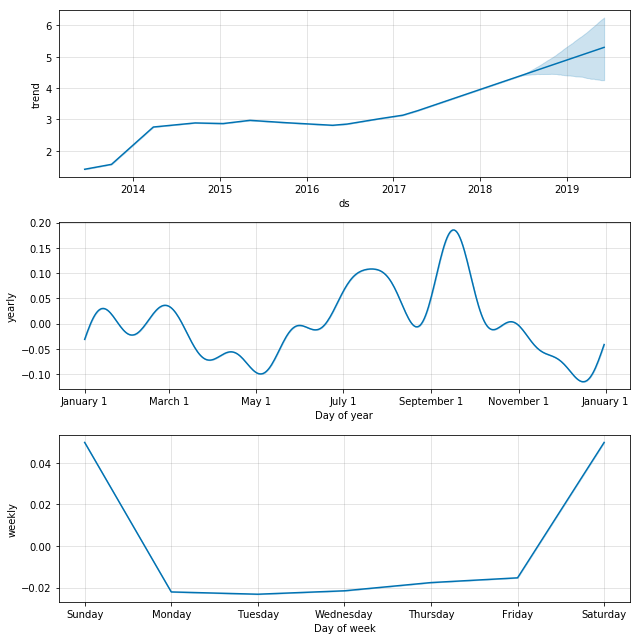

In [34]:
stock1_prophet.plot_components(stock1_forecast)

Now, we build a prophet model for the historical data of second potential companies we chose.

In [68]:
# Make the prophet model and fit on the stocks prices of Eco World
stock2_prophet = Prophet(interval_width=0.95, changepoint_prior_scale=0.05, daily_seasonality=False)
stock2_prophet.fit(stock_price2)

# Make a future dataframe for 1 year
stock2_forecast = stock2_prophet.make_future_dataframe(periods=365 * 1, freq='D')
# Make predictions
stock2_forecast = stock2_prophet.predict(stock2_forecast)
stock2_forecast.tail()

C:\anaconda\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
1584,2019-06-03,0.826983,-0.087319,1.649480,-0.153806,1.670096,-0.014849,-0.014849,-0.014849,0.0,0.0,0.0,-0.046611,-0.046611,-0.046611,0.031762,0.031762,0.031762,0.812134
1585,2019-06-04,0.825849,-0.090923,1.650944,-0.167551,1.723287,-0.014951,-0.014951,-0.014951,0.0,0.0,0.0,-0.048196,-0.048196,-0.048196,0.033245,0.033245,0.033245,0.810897
1586,2019-06-05,0.824714,-0.094527,1.652407,-0.140827,1.709384,-0.014315,-0.014315,-0.014315,0.0,0.0,0.0,-0.048989,-0.048989,-0.048989,0.034674,0.034674,0.034674,0.810399
1587,2019-06-06,0.823579,-0.098131,1.654749,-0.119656,1.691554,-0.007443,-0.007443,-0.007443,0.0,0.0,0.0,-0.043505,-0.043505,-0.043505,0.036062,0.036062,0.036062,0.816136
1588,2019-06-07,0.822444,-0.101735,1.659063,-0.146816,1.719651,-0.010431,-0.010431,-0.010431,0.0,0.0,0.0,-0.047853,-0.047853,-0.047853,0.037422,0.037422,0.037422,0.812013


In [70]:
stock2_prophet.changepoints

39    2013-08-02
78    2013-10-02
117   2013-11-28
156   2014-01-28
196   2014-03-27
235   2014-05-26
274   2014-07-21
313   2014-09-18
352   2014-11-14
391   2015-01-12
430   2015-03-12
469   2015-05-08
509   2015-07-03
548   2015-08-28
587   2015-10-28
626   2015-12-23
665   2016-02-25
704   2016-04-20
743   2016-06-15
782   2016-08-12
822   2016-10-13
861   2016-12-07
900   2017-02-07
939   2017-04-04
978   2017-06-01
Name: ds, dtype: datetime64[ns]

Text(0.5,1,'Stock Price of Eco World Develop Group')

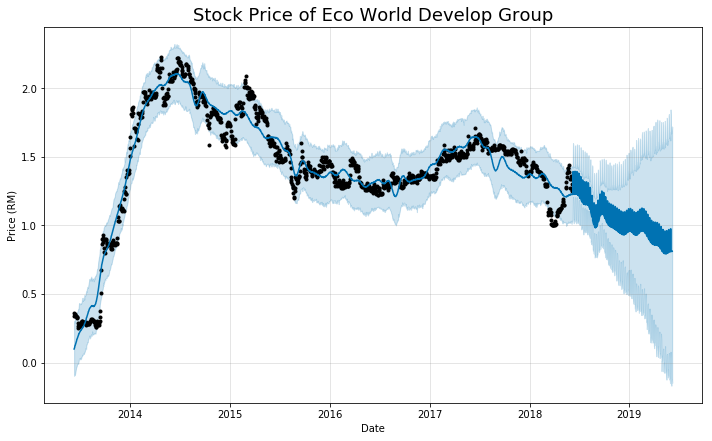

In [69]:
stock2_prophet.plot(stock2_forecast, xlabel = 'Date', ylabel = 'Price (RM)')
plt.title('Stock Price of '+stock_picked2, size=18)

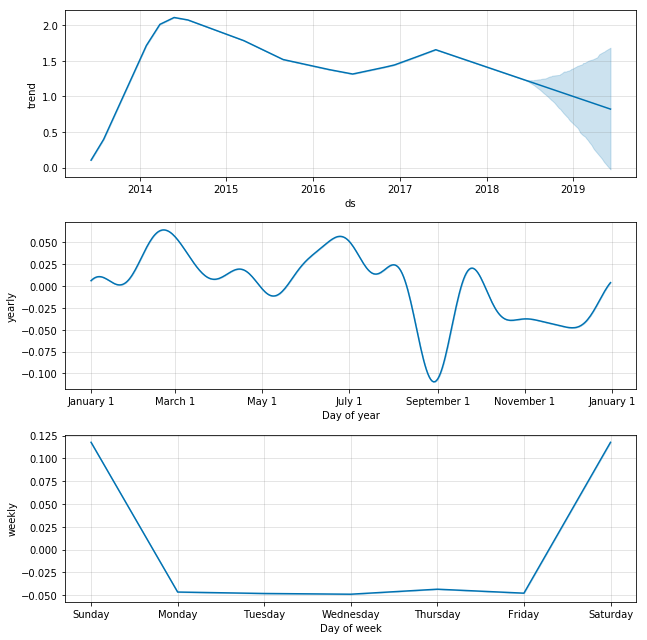

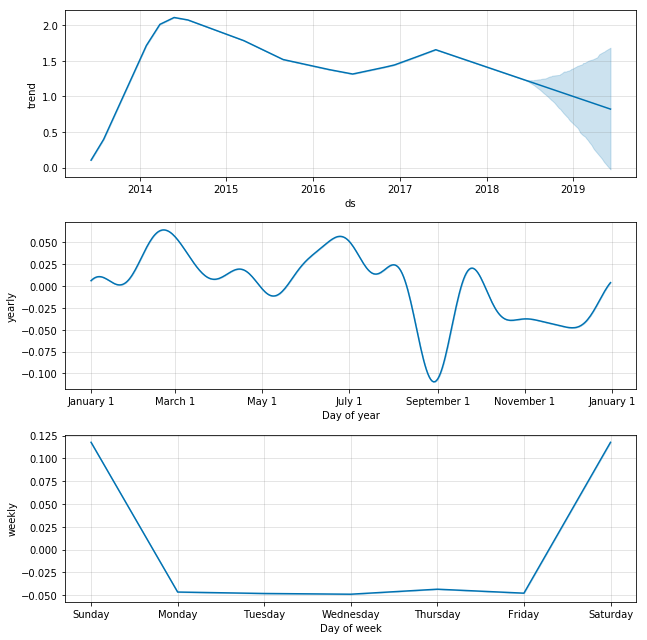

In [72]:
stock2_prophet.plot_components(stock2_forecast)

### Cross-validation(Model Evaluation)

To ensure our model work properly, we have to validate the model using **cross validation method**. Cross validation is a model validation techniques for assessing how the results of a statistical analysis will generalize to an independent data set. It combines (averages) measures of fitness in prediction to derive a more accurate estimate of model prediction performance. 

Time series data cannot be shuffled randomly, because we will lose its natural order. To do cross validation on time series data, we can only use the data in the past as training data and predict the new unseen data in future. In the cross validation, we are going to **predict one year data(365 days) using the model trained with 3 years historical data(1095 days) and rolling the validation by every 45 days**.

In [70]:
# cross-validation
stock1_cv = cross_validation(stock1_prophet, initial = '1095 days', horizon = '365 days', period = '45 days')
stock2_cv = cross_validation(stock2_prophet,  initial = '1095 days', horizon = '365 days', period = '45 days')

INFO:fbprophet.diagnostics:Making 9 forecasts with cutoffs between 2016-06-12 00:00:00 and 2017-06-07 00:00:00
C:\anaconda\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

INFO:fbprophet.diagnostics:Making 9 forecasts with cutoffs between 2016-06-12 00:00:00 and 2017-06-07 00:00:00


In [38]:
stock1_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-06-13,2.625072,2.401648,2.847035,2.71,2016-06-12
1,2016-06-14,2.615149,2.396071,2.846990,2.73,2016-06-12
2,2016-06-15,2.617822,2.380008,2.835357,2.72,2016-06-12
3,2016-06-16,2.617955,2.384092,2.837816,2.72,2016-06-12
4,2016-06-17,2.617143,2.398248,2.855499,2.72,2016-06-12


In [39]:
stock2_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-06-13,1.183535,1.018230,1.343924,1.28,2016-06-12
1,2016-06-14,1.179296,1.026701,1.339652,1.27,2016-06-12
2,2016-06-15,1.173354,1.008956,1.353837,1.26,2016-06-12
3,2016-06-16,1.177672,1.017028,1.351216,1.25,2016-06-12
4,2016-06-17,1.171660,0.999963,1.341230,1.23,2016-06-12


Let's check the results of the validation process using the self-defined function <font color='green'>*metrics_calculation*</font>. The outputs(**MAE, MAPE and RMSE**) from this function can tell us **how good is our predictive models**.

In [71]:
metrics_calculation(data = stock1_cv)

{'MAE': 0.37575757524883907,
 'MAPE': 0.11012390083710542,
 'RMSE': 0.48181602406208246}

In [72]:
metrics_calculation(data = stock2_cv)

{'MAE': 0.2301621164819446,
 'MAPE': 0.1627647666496559,
 'RMSE': 0.30666997436679605}

From the prophet plots above, we can notice both models do a good job of **capturing the main sources of variability** in the data. The **mean absolute percentage error** of the two models are 11% and 16.3% respectively. The results from the cross-validation also show us the models are good for predicting the future stock prices. These models will be used for prediction and we won't discuss the model optimization in this project.

The models can be improved by tuning the hyperparameters, adding significant exogenous independent variables or ensembling. You can check these information in the plan of future work in [Conclusion](#Conclusion).

### Comparisons of two stocks

Now that we are satisfied with the time series models, we can make prediction and compare the predicted stocks prices in the future. The information of both stocks are aggregated into a new dataframe for the ease of visualizing, we also check whether the data are merged appropiately and remove the duplicated date column.

In [74]:
# Combine the trends of stocks picked
stock1_names = [stock_picked1+'_%s' % column for column in stock1_forecast.columns]
stock2_names = [stock_picked2+'_%s' % column for column in stock2_forecast.columns]

# merge the dataframe
copy_stock1_forecast = stock1_forecast.copy()
copy_stock2_forecast = stock2_forecast.copy()

# Rename the columns
copy_stock1_forecast.columns = stock1_names
copy_stock2_forecast.columns = stock2_names

# Merge two datasets
forecast = pd.merge(copy_stock1_forecast, copy_stock2_forecast, how = 'inner',
                    left_on = stock_picked1+'_ds', right_on = stock_picked2+'_ds')

# make sure the merging is successful
forecast.isnull().any()
# Rename date column
forecast = forecast.rename(columns={stock_picked1+'_ds': 'Date'}).drop(stock_picked2+'_ds',axis=1)

We are now ready to visualize the forecasted time series data with the historical trends. The time series data will be visualized with 95% confidence interval by using the upper and lower bound of forecasted prices.

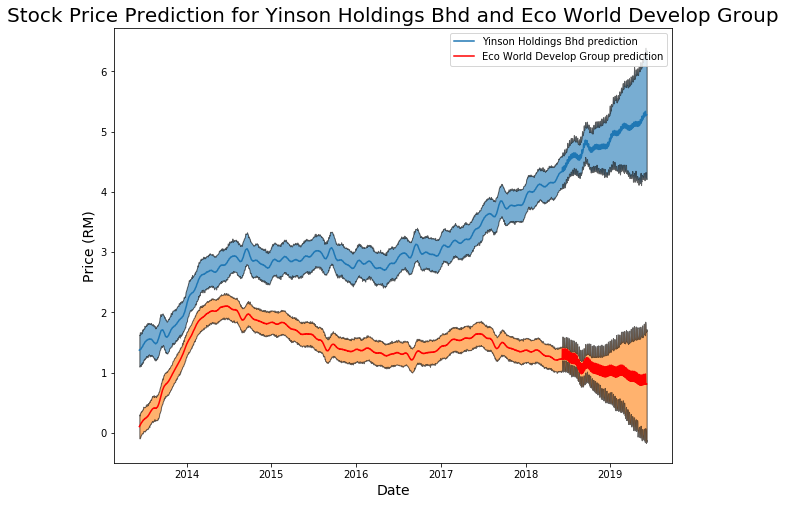

In [75]:
# Create subplots to set figure size
fig2, ax2 = plt.subplots(1, 1, figsize=(10, 8));
# Plot estimate and uncertainty for stock1
ax2.plot(forecast['Date'], forecast[stock_picked1+'_yhat'], label = stock_picked1+' prediction');
ax2.fill_between(forecast['Date'].dt.to_pydatetime(), forecast[stock_picked1+'_yhat_upper'], forecast[stock_picked1+'_yhat_lower'], alpha=0.6, edgecolor = 'k');
# Plot estimate and uncertainty for stock2
ax2.plot(forecast['Date'], forecast[stock_picked2+'_yhat'], 'r', label = stock_picked2+' prediction');
ax2.fill_between(forecast['Date'].dt.to_pydatetime(), forecast[stock_picked2+'_yhat_upper'], forecast[stock_picked2+'_yhat_lower'], alpha=0.6, edgecolor = 'k');
plt.legend();
plt.xlabel('Date', size=14); plt.ylabel('Price (RM)', size=14); plt.title('Stock Price Prediction for '+stock_picked1+' and '+stock_picked2, size=20);

The dark blue and orange lines are the **forecasted prices** of the stock pairs, wihle the light blue and light orange shaded regions around the lines are the **uncertainty of the forecasting(95% confidence interval)**.The region of uncertainty increases further out in the future the prediction is made because initial uncertainty propagates and grows over time. The plot show us the predicted difference of prices between the stock pairs is increasing over time, the stocks price of **Yinson Holdings Bhd** will be **more than 5 times** of the price of Eco World Group Bhd in the **middle of 2019**.

### Expected value in next 1 year

In [76]:
# Extract the expected value in 1 years later 
value_end_stock1 = stock1_forecast['yhat'].iloc[-1]
value_end_stock2 = stock2_forecast['yhat'].iloc[-1]
# Extract the last day in our forecasting period
day_end_stock1 = stock1_forecast['ds'].iloc[-1]
day_end_stock2 = stock2_forecast['ds'].iloc[-1]

# Growth
growth_stock1 = (value_end_stock1 - stock_price1['y'].iloc[-1]) / stock_price1['y'].iloc[-1]
growth_stock2 = (value_end_stock2 - stock_price2['y'].iloc[-1]) / stock_price2['y'].iloc[-1]

In [77]:
print('Based on our analysis, we expect the stock price of \n' + 
      stock_picked1 + ' is RM' + str(round(value_end_stock1,3)) + ' on ' + str(day_end_stock1) + ' , change from last price is '+ str(round(growth_stock1*100,2)) + '%,\n' +
      stock_picked2 + ' is RM' + str(round(value_end_stock2,3)) +' on ' + str(day_end_stock2) + ' , change from last price is '+ str(round(growth_stock2*100,2)) + '%.')

Based on our analysis, we expect the stock price of 
Yinson Holdings Bhd is RM5.278 on 2019-06-07 00:00:00 , change from last price is 14.24%,
Eco World Develop Group is RM0.812 on 2019-06-07 00:00:00 , change from last price is -36.06%.


Based on the results above, we know that the stock price of Yinson is predicted to soar to RM5.278 in next one year while Eco World is predicted to shrink to under RM1 per unit, only value for RM0.812 in the mid 2019. From the visualization, we found that the Yinson keep going up since the mid 2013 but Eco World continue to shrink from the middle of 2014 after skyrocket in 2013.

If you decide to invest in **Yinson** stock now, you are expected to have **14.24% gain in mid 2019**, but you are expected to **lose 36.06%** if you buy the **Eco World** stock. Let's say we are going to buy one of these stocks with RM 10,000, the value of Yinson and Eco World stocks are anticipated to change to RM 11,424 and RM 6,394 respectively in the middle of 2019.

This **time series analysis provide us a good picture about the movement of stocks prices in next one year**. Some high growth stocks screened out and their correlations have been assessed and clustered with stocks which have the similar trend in the past. To balance the past performance and the investment diversification, we are adviced to invest in the stocks which are less correlated from different clusters. Lastly, the time series analysis is used to predict the future value of the stock pairs, which gives us some valuable insights about the movement of the prices.

<a id='Conclusion'></a>

## 6. Conclusion

The quantitative analysis is powerful and useful for identifying the patterns and exploring the stock market. At the beginning of this note, we retrieve the historical prices and related performance indexes from multiple webpages and the data manipulation process has been taken care in the custom function that we won't need to worry about that.  

To investigate the **growth of stocks**, we compute the **mean and standard deviation of the daily return** which are the useful performance metrics that quantitatively characterize risk and reward of the stocks. **Correlation analysis** used to identify the extent to which assets are correlated. The correlation and historical performance should be considered and balanced to **optimize the portfolio construction**.

The Prophet additive models developed to **identify patterns and trends from historical prices**, and they are used to **predict the future movement of the stock prices**. Additive models are useful because they are quick to develop, fast to train, provide interpretable patterns, and make predictions with uncertainties. If we are using these additive models to actively trade, we would need to train a new time series model and **update the predictions** with new daily prices. 

This **stock screening workflow** gives us an **overview of Malaysia stock market and provides some valuable insights for making better investment decisions**. This has filtered out some potential stocks with combining the prediction about the future values.

We have seen many **interesting results** in this work but there are some possible approaches for **improving the model in future work**.
1. Develop different time series models: Stochastic, ARIMA and recurrent neural networks with LSTM cells are some popular time series models.
2. Optimize time series model: Grid search can be used to tune the hyperparameter of the time series model and ensembling technique can be used to boost the accuracy of the predictive models.
3. Add financial performance indicators: Selecting investment on single statistics is never a good idea. P/E ratio, revenue, profit and dividends are some important financial performance indicators of a company, taking them into consideration can give us a whole picture about the business performance of company. 

[Top](#Top)